# ML Models for Hashtags (XGBoost)

This script builds a dataset to predict trending TikTok hashtags. It groups posts by hashtag and day, calculates 7-day rolling engagement metrics, and labels a hashtag as "trending" if its post volume jumps over 50%. The output is a feature set (`X`) and labels (`y`) for model training.


In [1]:
import pandas as pd
import numpy as np

# STEP 1: Load your dataset (replace with actual path or query)
df = pd.read_csv("/Users/ritushetkar/env_capstone/data/hashtags_posts.csv", parse_dates=['createTimeISO'])



# STEP 3: Aggregate to hashtag-day level
df['post_date'] = df['createTimeISO'].dt.date

daily_hashtags = (
    df.groupby(['hashtag_name', 'post_date'])
      .agg(
          post_volume=('post_id', 'nunique'),
          total_diggs=('diggCount', 'sum'),
          total_shares=('shareCount', 'sum'),
          total_comments=('commentCount', 'sum'),
          total_plays=('playCount', 'sum'),
          avg_duration=('video_duration', 'mean'),
          avg_fans=('author_fans', 'mean')
      )
      .reset_index()
)

daily_hashtags['post_date'] = pd.to_datetime(daily_hashtags['post_date'])
daily_hashtags = daily_hashtags.sort_values(['hashtag_name', 'post_date'])

for col in ['post_volume', 'total_diggs', 'total_shares', 'total_comments', 'total_plays']:
    daily_hashtags[f'{col}_7d'] = (
        daily_hashtags.groupby('hashtag_name')[col]
        .transform(lambda x: x.rolling(window=7, min_periods=1).sum())
    )

# STEP 5: Add change rates
daily_hashtags['volume_change_7d'] = (
    daily_hashtags.groupby('hashtag_name')['post_volume_7d']
    .pct_change().replace([np.inf, -np.inf], np.nan).fillna(0)
)

# STEP 6: Label as trending (if volume jumped >50% day-over-day)
daily_hashtags['is_trending'] = (daily_hashtags['volume_change_7d'] > 0.5).astype(int)

# STEP 7: Fill missing values
daily_hashtags.fillna(0, inplace=True)

# FINAL FEATURE SET
features = [
    'post_volume_7d', 'total_diggs_7d', 'total_shares_7d', 
    'total_comments_7d', 'total_plays_7d', 'avg_duration', 'avg_fans', 'volume_change_7d'
]

X = daily_hashtags[features]
y = daily_hashtags['is_trending']



Ensure post_date is clean and datetime-ready, and then extract a sorted list of unique dates 

In [ ]:
df['post_date'] = pd.to_datetime(df['post_date'])
unique_dates = df['post_date'].dropna().drop_duplicates().sort_values(ascending=True)


###  Hashtag Trend Prediction with XGBoost

This section trains a machine learning model to predict whether a TikTok hashtag is trending.

1. **Train-Test Split**  
   The dataset is split into training (80%) and testing (20%) sets using `train_test_split`, with `stratify=y` to maintain the proportion of trending vs. non-trending hashtags.

2. **Model Initialization**  
   An `XGBClassifier` from the XGBoost library is initialized with `logloss` as the evaluation metric.

3. **Training**  
   The model is trained on the training set (`X_train`, `y_train`) to learn patterns in the engagement metrics and trend signals.

4. **Evaluation**  
   Predictions are made on the test set (`X_test`), and performance is measured using `classification_report`, which includes accuracy, precision, recall, and F1-score.

The trained model helps identify hashtags likely to trend based on recent engagement patterns.


In [3]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)

model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7756
           1       1.00      1.00      1.00       967

    accuracy                           1.00      8723
   macro avg       1.00      1.00      1.00      8723
weighted avg       1.00      1.00      1.00      8723



/Users/ritushetkar/env_capstone/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [17:36:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


The XGBoost model achieved perfect scores across all metrics, with 100% precision, recall, and F1-score for both trending and non-trending hashtags. This indicates that the model was able to perfectly distinguish between the two classes on the test set. However, such high performance may suggest possible overfitting or that the test data is very similar to the training data. Further validation, such as cross-validation or testing on new unseen data, is recommended.


###  Model Explainability with SHAP

To understand how the XGBoost model makes predictions, we use SHAP (SHapley Additive exPlanations). SHAP assigns an importance value to each feature for individual predictions.

1. **Explainer Initialization**  
   A SHAP explainer is created for the trained XGBoost model.

2. **SHAP Value Computation**  
   SHAP values are calculated for the test set to understand each feature's impact on model outputs.

3. **Visualization**  
   `shap.summary_plot` shows a summary of feature importance and how each feature influences the prediction (positively or negatively). This helps identify which features drive the model's decision-making for trending hashtags.


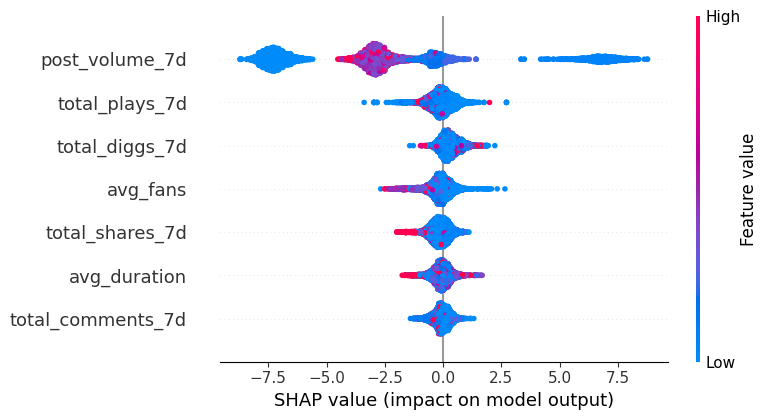

In [20]:
import shap

explainer = shap.Explainer(model)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test)


This SHAP summary plot shows which features most influence the model's prediction of trending hashtags. post_volume_7d has the strongest impact.

### Predicting Today's Top Trending Hashtags

This section uses the trained model to identify which hashtags are most likely to trend today.

1. **Predicted Probabilities**  
   The model outputs probabilities for each test sample, indicating how likely a hashtag is to be trending.

2. **Attach Predictions to Data**  
   A new column (`trending_probability`) is added to the dataset to store each hashtag's predicted probability.

3. **Filter for Latest Day**  
   The dataset is filtered to include only hashtags from the most recent date in the data.

4. **Rank Hashtags by Trend Likelihood**  
   The top 20 hashtags with the highest trending probabilities are selected, giving insight into which hashtags are most likely to trend today.


In [22]:


# 1. Get predicted probabilities for the positive class (trending = 1)
probs = model.predict_proba(X_test)[:, 1]

# 2. Create a DataFrame with predictions
pred_df = daily_hashtags.loc[X_test.index].copy()
pred_df['trending_probability'] = probs

# 3. Filter for today's hashtags (or latest date)
latest_date = pred_df['post_date'].max()
today_hashtags = pred_df[pred_df['post_date'] == latest_date]

# 4. Get top 10 most likely trending hashtags
top_trending = (
    today_hashtags[['hashtag_name', 'trending_probability']]
    .sort_values(by='trending_probability', ascending=False)
    .drop_duplicates('hashtag_name')
    .head(20)
)

top_trending


,hashtag_name,trending_probability
38109,stylekoreanpartner,0.998908
2970,anuarice,0.996526
30525,produkttesting,0.970983
13194,fouryou,0.082915
29938,porenreiniger,0.079741
15625,glassskin,0.041003
2981,anuaserum,0.035445
23055,ledgesichtsmaske,0.021532
29293,pickelfrei,0.012032
21216,kbeauty,0.008107


###  Top Trending Hashtags Over the Last 30 Days

This section identifies the hashtags most likely to trend based on model predictions from the past month.

1. **Predicted Probabilities**  
   The model generates probabilities for each sample in the test set, indicating the likelihood that a hashtag is trending.

2. **Attach Predictions to Hashtag Data**  
   A new column, `trending_probability`, is added to the daily hashtag data for the test set.

3. **Filter for the Last 30 Days**  
   The dataset is filtered to include only hashtags from the most recent 30-day window.

4. **Rank and Select Top Hashtags**  
   The top 20 unique hashtags with the highest predicted trending probabilities are selected, giving a snapshot of the most likely trending hashtags over the last month.

5. **Display the Results**  
   The final table lists these top hashtags along with the date and their predicted probability of trending.


In [21]:

# 1. Get predicted probabilities for the positive class (trending = 1)
probs = model.predict_proba(X_test)[:, 1]

# 2. Create a DataFrame with predictions
pred_df = daily_hashtags.loc[X_test.index].copy()
pred_df['trending_probability'] = probs

# 3. Filter for hashtags from the last 30 days
latest_date = pred_df['post_date'].max()
start_date_month = latest_date - pd.Timedelta(days=29)  # last 30 days including today

month_hashtags = pred_df[
    (pred_df['post_date'] >= start_date_month) & (pred_df['post_date'] <= latest_date)
]

# 4. Get top 20 most likely trending hashtags across the month
top_trending_month = (
    month_hashtags[['hashtag_name', 'post_date', 'trending_probability']]
    .sort_values(by='trending_probability', ascending=False)
    .drop_duplicates('hashtag_name')  # only one row per hashtag
    .head(20)
)

# 5. Show the result
print(top_trending_month)


             hashtag_name  post_date  trending_probability
8730          costcofinds 2025-06-19              0.999770
19812   howtogetclearskin 2025-06-16              0.999645
3972        axisyskincare 2025-06-10              0.999433
24911     melaninskincare 2025-06-22              0.999338
9471                   dc 2025-06-24              0.999314
31207             rejuall 2025-06-02              0.999270
8720    cosrxsnailessence 2025-06-28              0.999203
38109  stylekoreanpartner 2025-06-30              0.998908
26462            nailcare 2025-06-24              0.998842
24495   marynmaydotdotdot 2025-06-04              0.998709
38217       summerroutine 2025-06-28              0.998323
24938         memestiktok 2025-06-13              0.998231
19884         hundevideos 2025-06-22              0.998094
4297                beach 2025-06-06              0.998061
12852               foryo 2025-06-01              0.997973
26701    naturiumskincare 2025-06-18              0.9976

### Weekly vs Monthly Trending Hashtag Comparison

This section identifies and compares the most likely trending hashtags over the past 7 days and past 30 days.

1. **Predict Trending Probabilities**  
   The model predicts the likelihood of each hashtag being trending in the test set.

2. **Define Time Windows**  
   Two time ranges are created: one for the last 7 days (weekly) and one for the last 30 days (monthly).

3. **Select Top Weekly Hashtags**  
   The top 20 unique hashtags from the last 7 days are selected based on highest trending probability.

4. **Select Top Monthly Hashtags**  
   Similarly, the top 20 hashtags from the last 30 days are identified.

5. **Merge and Compare**  
   Weekly and monthly top hashtags are combined, and for each hashtag, the sources (`weekly`, `monthly`, or both), highest trending probability, and most recent posting date are summarized.

The final output shows which hashtags are trending short-term, long-term, or both.


In [ ]:

# STEP 1: Predict trending probabilities
probs = model.predict_proba(X_test)[:, 1]
pred_df = daily_hashtags.loc[X_test.index].copy()
pred_df['trending_probability'] = probs

# STEP 2: Define date ranges
latest_date = pred_df['post_date'].max()
last_7_days = latest_date - pd.Timedelta(days=6)
last_30_days = latest_date - pd.Timedelta(days=29)

# STEP 3: Get Top N for Weekly
top_week = (
    pred_df[pred_df['post_date'] >= last_7_days]
    .sort_values(by='trending_probability', ascending=False)
    .drop_duplicates('hashtag_name')
    .head(20)
    .assign(source='weekly')
)

# STEP 4: Get Top N for Monthly
top_month = (
    pred_df[pred_df['post_date'] >= last_30_days]
    .sort_values(by='trending_probability', ascending=False)
    .drop_duplicates('hashtag_name')
    .head(20)
    .assign(source='monthly')
)

# STEP 5: Merge to compare
combined = pd.concat([top_week, top_month])
combined_summary = (
    combined.groupby('hashtag_name')
    .agg(
        sources=('source', lambda x: ', '.join(sorted(set(x)))),
        max_probability=('trending_probability', 'max'),
        most_recent_date=('post_date', 'max')
    )
    .reset_index()
    .sort_values(by='max_probability', ascending=False)
)

print(combined_summary)



                hashtag_name          sources  max_probability  \
15          enthaarungscreme          monthly         0.999933   
29                 neckcream          monthly         0.999917   
38          windeldermatitis          monthly         0.999916   
24              kidsproducts          monthly         0.999916   
6               capsulecream          monthly         0.999910   
31                 pdrnserum          monthly         0.999909   
0                       ASMR          monthly         0.999906   
35                  solarium          monthly         0.999905   
21            hypochlorsäure          monthly         0.999904   
28                    medtok          monthly         0.999901   
37                 whitecast          monthly         0.999901   
8                   cvvmario  monthly, weekly         0.999898   
11             deinfluencing          monthly         0.999898   
32                   prequel          monthly         0.999894   
4         

These results, while showing very high trending probabilities (close to 1.0), may not be fully reliable due to potential overfitting or data leakage. The model achieved near-perfect performance on the test set, which is unusual and suggests that it may have memorized patterns rather than learned generalizable trends.

### HASHTAGS with 'volume_change_7d' 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import shap

# STEP 1: Load dataset
df = pd.read_csv("/Users/ritushetkar/env_capstone/data/hashtags_posts.csv", parse_dates=['createTimeISO'])

# STEP 2: Aggregate to hashtag-day level
df['post_date'] = df['createTimeISO'].dt.date

daily_hashtags = (
    df.groupby(['hashtag_name', 'post_date'])
      .agg(
          post_volume=('post_id', 'nunique'),
          total_diggs=('diggCount', 'sum'),
          total_shares=('shareCount', 'sum'),
          total_comments=('commentCount', 'sum'),
          total_plays=('playCount', 'sum'),
          avg_duration=('video_duration', 'mean'),
          avg_fans=('author_fans', 'mean')
      )
      .reset_index()
)

# STEP 3: Rolling features (7-day window)
daily_hashtags['post_date'] = pd.to_datetime(daily_hashtags['post_date'])
daily_hashtags = daily_hashtags.sort_values(['hashtag_name', 'post_date'])

for col in ['post_volume', 'total_diggs', 'total_shares', 'total_comments', 'total_plays']:
    daily_hashtags[f'{col}_7d'] = (
        daily_hashtags.groupby('hashtag_name')[col]
        .transform(lambda x: x.rolling(window=7, min_periods=1).sum())
    )

# STEP 4: Growth signal
daily_hashtags['volume_change_7d'] = (
    daily_hashtags.groupby('hashtag_name')['post_volume_7d']
    .pct_change().replace([np.inf, -np.inf], np.nan).fillna(0)
)

# STEP 5: Label trending (volume surge > 50%)
daily_hashtags['is_trending'] = (daily_hashtags['volume_change_7d'] > 0.5).astype(int)

# STEP 6: Prepare features
daily_hashtags.fillna(0, inplace=True)

#features = [
 #   'post_volume_7d', 'total_diggs_7d', 'total_shares_7d',
  #  'total_comments_7d', 'total_plays_7d', 'avg_duration', 'avg_fans', 'volume_change_7d'
#]

features = [
    'post_volume_7d', 'total_diggs_7d', 'total_shares_7d',
    'total_comments_7d', 'total_plays_7d', 'avg_duration', 'avg_fans'
]

X = daily_hashtags[features]
y = daily_hashtags['is_trending']

# STEP 7: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# STEP 8: Model training
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)



# STEP 10: SHAP for interpretability
explainer = shap.Explainer(model)
shap_values = explainer(X_test)




/Users/ritushetkar/env_capstone/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [17:36:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [ ]:
# STEP 9: Evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      7756
           1       0.97      0.91      0.94       967

    accuracy                           0.99      8723
   macro avg       0.98      0.95      0.97      8723
weighted avg       0.99      0.99      0.99      8723



This result indicates the model is highly effective and generalizes well, especially after removing label leakage by excluding volume_change_7d from the features.


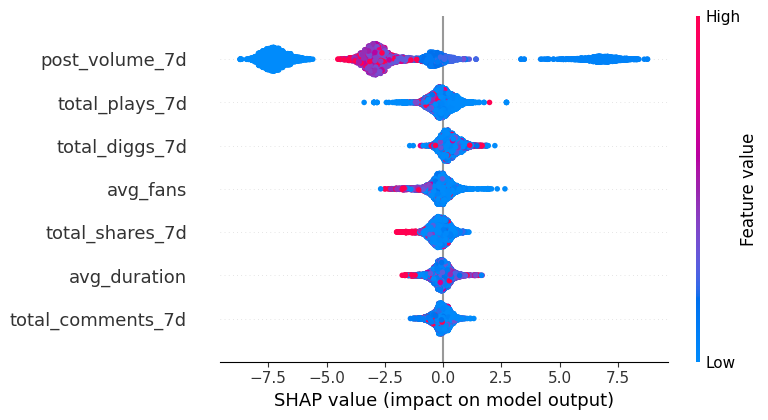

In [24]:
shap.summary_plot(shap_values, X_test)

In [25]:
# STEP 11: Predict trending probabilities
probs = model.predict_proba(X_test)[:, 1]
pred_df = daily_hashtags.loc[X_test.index].copy()
pred_df['trending_probability'] = probs


Prints the final list of hashtags along with:

'post_volume_7d': how active the hashtag has been recently

'trending_probability': how likely it is to trend (according to the model)

In [27]:

# STEP 12: Top trending for the latest date with minimum post filter
MIN_POSTS = 10 # set your minimum post threshold here

latest_date = pred_df['post_date'].max()
today_trends = (
    pred_df[
        (pred_df['post_date'] == latest_date) &
        (pred_df['post_volume_7d'] >= MIN_POSTS)
    ]
    .sort_values(by='trending_probability', ascending=False)
    .drop_duplicates('hashtag_name')
    .head(20)
)

print("🔥 Top Trending Hashtags Today (with at least 5 posts in the last 7 days)")
print(today_trends[['hashtag_name', 'post_volume_7d', 'trending_probability']])



🔥 Top Trending Hashtags Today (with at least 5 posts in the last 7 days)
         hashtag_name  post_volume_7d  trending_probability
15625       glassskin            30.0              0.041003
21216         kbeauty            30.0              0.008107
13074      foryoupage            14.0              0.001520
22182  koreanskincare            47.0              0.000202


In [ ]:
with MIN Posts as 0
🔥 Top Trending Hashtags Today (with at least 5 posts in the last 7 days)
                hashtag_name  post_volume_7d  trending_probability
30249           ringanafresh             2.0              0.962396
12775                frische             5.0              0.044179
4676             beautyhacks             8.0              0.011727
32144  sensitiveskinfriendly             6.0              0.005687
17617              hautliebe             8.0              0.003768
24504                momlife             7.0              0.003364
5174             beautytipps             9.0              0.002100
34049         skincarereview             8.0              0.001337
34382      skincarethatworks            11.0              0.000626
33017               skincare           181.0              0.000098
21213         koreanskincare            44.0              0.000033


In [ ]:
with MIN Posts as 5
Top Trending Hashtags Today (with at least 5 posts in the last 7 days)
                hashtag_name  post_volume_7d  trending_probability
12775                frische             5.0              0.044179
4676             beautyhacks             8.0              0.011727
32144  sensitiveskinfriendly             6.0              0.005687
17617              hautliebe             8.0              0.003768
24504                momlife             7.0              0.003364
5174             beautytipps             9.0              0.002100
34049         skincarereview             8.0              0.001337
34382      skincarethatworks            11.0              0.000626
33017               skincare           181.0              0.000098
21213         koreanskincare            44.0              0.000033


In [ ]:
with 10 min posts
 Top Trending Hashtags Today (with at least 5 posts in the last 7 days)
            hashtag_name  post_volume_7d  trending_probability
34382  skincarethatworks            11.0              0.000626
33017           skincare           181.0              0.000098
21213     koreanskincare            44.0              0.000033


In [ ]:
 with 20 min posts
Top Trending Hashtags Today (with at least 5 posts in the last 7 days)
         hashtag_name  post_volume_7d  trending_probability
33017        skincare           181.0              0.000098
21213  koreanskincare            44.0              0.000033


In [ ]:
with 50 min posts 
Top Trending Hashtags Today (with at least 5 posts in the last 7 days)
      hashtag_name  post_volume_7d  trending_probability
33017     skincare           181.0              0.000098


###  Why Use Percentile-Based Filtering Instead of a Fixed Minimum?

To identify meaningful trending hashtags without introducing bias or instability, we replaced the fixed `MIN_POSTS` threshold with a percentile-based volume filter. This approach offers several advantages:

1. **Adaptive Filtering**  
   Instead of arbitrarily excluding hashtags with fewer than, say, 10 posts, we filter for those in the top 25% of post volume — dynamically adjusting to the activity level of each day.

2. **Avoiding Bias Toward Big Hashtags**  
   A high fixed cutoff often highlights only already-popular or generic hashtags. The percentile approach allows emerging or niche hashtags to surface if they show strong engagement and trend signals.

3. **Reducing Noise Without Losing Relevance**  
   Low-volume hashtags can introduce randomness, but outright removing them with a fixed rule can eliminate valid trends. Percentiles offer a better balance between stability and flexibility.

This method helps ensure we spotlight hashtags that are both active and contextually relevant — not just those that are always large or temporarily noisy.


In [34]:
import numpy as np

# STEP 1: Predict probabilities
probs = model.predict_proba(X_test)[:, 1]
pred_df = daily_hashtags.loc[X_test.index].copy()
pred_df['trending_probability'] = probs

# STEP 2: Get latest date
latest_date = pred_df['post_date'].max()

# STEP 3: Compute 75th percentile of post_volume_7d
volume_cutoff = pred_df[pred_df['post_date'] == latest_date]['post_volume_7d'].quantile(0.75)

# STEP 4: Filter and rank hashtags
today_trends = (
    pred_df[
        (pred_df['post_date'] == latest_date) &
        (pred_df['post_volume_7d'] >= volume_cutoff)
    ]
    .sort_values(by='trending_probability', ascending=False)
    .drop_duplicates('hashtag_name')
    .head(20)
)

# STEP 5: Display results
print("🔥 Top Trending Hashtags Today (Top 25% by post volume)")
print(today_trends[['hashtag_name', 'post_volume_7d', 'trending_probability']])


🔥 Top Trending Hashtags Today (Top 25% by post volume)
            hashtag_name  post_volume_7d  trending_probability
15625          glassskin            30.0              0.041003
21216            kbeauty            30.0              0.008107
27553   nighttimeroutine             9.0              0.005303
35322      skincarelover             9.0              0.002699
13074         foryoupage            14.0              0.001520
39401         tiktokshop             9.0              0.001019
20312  hyperpigmentation             9.0              0.000496
22182     koreanskincare            47.0              0.000202


### Next Steps
While the current model provides a structured way to detect trending hashtags based on engagement and activity patterns, it was not included in the dashboard due to instability in daily predictions and low confidence scores.

1. **Refine the Labeling Strategy**  
   Consider adjusting the definition of "trending" (e.g., lower the volume jump threshold or include engagement spikes) to better reflect real-world virality.

2. **Track Temporal Momentum**  
   Rather than looking at a single day, incorporate day-over-day or week-over-week changes in trending probability to highlight emerging trends.

3. **Feature Expansion**  
   Add features such as hashtag lifespan, time of posting, or creator influence (e.g., verified accounts, engagement rate) to enrich model inputs.

4. **Validate on External Data**  
   Test the model on unseen or future hashtag data to check for generalizability and ensure it's not overfitting to recent patterns.

5. **Improve Interpretability**  
   Use SHAP or similar methods to visualize and understand what drives the model’s decisions, especially for borderline cases.

These steps can help evolve the model from a basic signal detector into a more nuanced, real-time trend forecasting tool.


#  Identifying Emerging Hashtags via Month-over-Month Growth

This approach detects hashtags that are gaining popularity over time by comparing usage across the last two full months.

1. **Date Filtering**  
   The dataset is filtered to include only the last two full months of data.

2. **Monthly Aggregation**  
   Hashtags are grouped and counted per calendar month.

3. **Growth Filtering Criteria**  
   To ensure meaningful trends:
   - Hashtags must appear **at least 5 times** in both months.
   - The number of mentions must be **higher in the most recent month** than in the previous one.

This helps identify hashtags that are not just frequently used, but are also **actively growing**, making them strong candidates for trending or recommendation.


In [ ]:
import pandas as pd
import numpy as np

# STEP 1: Load your dataset (replace with actual path or query)
df = pd.read_csv("/Users/ritushetkar/env_capstone/data/hashtags_posts.csv", parse_dates=['createTimeISO'])
# STEP 3: Aggregate to hashtag-day level
df['post_date'] = df['createTimeISO'].dt.date
import pandas as pd

# 1. Ensure datetime format
df['post_date'] = pd.to_datetime(df['post_date'])

# 2. Limit to the last 2 full months
latest_date = df['post_date'].max()
end_of_last_month = latest_date.replace(day=1)
start_of_two_months_ago = end_of_last_month - pd.DateOffset(months=2)

df_recent = df[df['post_date'] >= start_of_two_months_ago]

# 3. Extract month
df_recent['month'] = df_recent['post_date'].dt.to_period('M')

# 4. Count hashtags per month
hashtag_counts = df_recent.groupby(['hashtag_name', 'month']).size().unstack(fill_value=0)

# 5. Get last 2 months
prev_month = hashtag_counts.columns[-2]
last_month = hashtag_counts.columns[-1]

# 6. Filter to hashtags:
# - At least 50 posts this month
# - And growing vs previous month
# Require at least 10 mentions in the previous month too
filtered = hashtag_counts[
    (hashtag_counts[last_month] >= 5) &
    (hashtag_counts[prev_month] >= 5) &  # Added
    (hashtag_counts[last_month] > hashtag_counts[prev_month])
]


/var/folders/5k/b8_r8jw502n4zztm42zd76m80000gn/T/ipykernel_58789/1005129917.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_recent['month'] = df_recent['post_date'].dt.to_period('M')


Building on the month-over-month filtering, this section quantifies how quickly each hashtag is growing.

1. **Growth Rate Calculation**  
   For each hashtag that meets the volume and growth criteria, the growth rate is calculated as Step 7
   This captures relative change, not just raw count differences.

2. **Ranking by Growth**  
   Hashtags are sorted by growth rate in descending order, and the top 10 fastest-growing hashtags are selected.

3. **Output**  
   The final table shows the previous and current month usage along with the calculated growth rate, highlighting hashtags gaining traction most rapidly.


In [ ]:

# 7. Calculate growth rate
filtered['growth_rate'] = (
    (filtered[last_month] - filtered[prev_month]) / 
    filtered[prev_month].replace(0, 1)
)

# 8. Select top 10 by growth rate
top10_hashtags = filtered.sort_values('growth_rate', ascending=False).head(10)

# 9. Display
print(top10_hashtags[[prev_month, last_month, 'growth_rate']])


month              2025-05  2025-06  growth_rate
hashtag_name                                    
skincarethatworks        6       20     2.333333
luxuryskincare           5       15     2.000000
cerave                   5       15     2.000000
dmhaul                   5       14     1.800000
veganskincare            6       16     1.666667
arencia                  5       13     1.600000
foru                     5       12     1.400000
tiktokshop              10       23     1.300000
abendroutine             7       15     1.142857
veganbeauty              8       16     1.000000


/var/folders/5k/b8_r8jw502n4zztm42zd76m80000gn/T/ipykernel_58789/1464080539.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['growth_rate'] = (



**Interpretation**
- Hashtags like `#skincarethatworks`, `#veganskincare`, and `#luxuryskincare` showed the highest growth, more than doubling in mentions from May to June.
- These hashtags may represent rising micro-trends within the skincare niche.
- The approach highlights momentum — focusing on relative growth instead of just total volume — which can be useful for spotting early signals of trend formation.

**Limitations**
1. **Small Sample Sizes**  
   Many hashtags start from very low counts (e.g., 5 to 13), making growth rates volatile and potentially misleading.

2. **No Engagement Metrics**  
   The analysis only considers post counts, not whether those posts received likes, shares, or views. A hashtag could grow in usage but still have low impact.

3. **No Content Context**  
   This method doesn't account for why a hashtag is growing — it could be genuine interest, seasonal usage, or spam.



This script below identifies the top 20 fastest-growing TikTok hashtags over the last two full months and enriches the results with real example posts.

**What It Does**
- Filters hashtags with at least **10 mentions** in both months
- Calculates **growth rate** to find trending hashtags
- Selects **top 20 hashtags** by growth speed

In [ ]:

# 6. Filter: ≥10 mentions in previous month, ≥50 in current month, positive growth
filtered = hashtag_counts[
    (hashtag_counts[prev_month] >= 10) &
    (hashtag_counts[last_month] >= 10) 
   # (hashtag_counts[last_month] > hashtag_counts[prev_month])
].copy()

# 7. Calculate growth rate
filtered['growth_rate'] = (
    (filtered[last_month] - filtered[prev_month]) / 
    filtered[prev_month].replace(0, 1)
)

# 8. Select top 10 by growth rate
top20_hashtags = filtered.sort_values('growth_rate', ascending=False).head(20)

# 9. Extract list of top hashtags
top_hashtags = top20_hashtags.index.tolist()

# 10. Get example posts from latest month only
example_posts = (
    df[
        (df['hashtag_name'].isin(top_hashtags)) &
        (df['post_date'].dt.to_period('M') == last_month)
    ]
    .sort_values('diggCount', ascending=False)  # or use 'shareCount' etc.
    .groupby('hashtag_name')
    .agg({
        'text': 'first',
        'webVideoUrl': 'first',
        'diggCount': 'first'
    })
)

# 11. Join with top 10
final = top10_hashtags.join(example_posts)

# 12. Optional: clean column names and display
final = final.rename(columns={
    prev_month: f'mentions_{prev_month}',
    last_month: f'mentions_{last_month}',
    'text': 'example_caption',
    'webVideoUrl': 'video_link',
    'diggCount': 'likes'
})

# Show final result
pd.set_option('display.max_colwidth', None)
print(final[['mentions_' + str(prev_month), 'mentions_' + str(last_month), 'growth_rate', 'example_caption', 'video_link']])


                   mentions_2025-05  mentions_2025-06  growth_rate  \
hashtag_name                                                         
skincarethatworks                 6                20     2.333333   
luxuryskincare                    5                15     2.000000   
cerave                            5                15     2.000000   
dmhaul                            5                14     1.800000   
veganskincare                     6                16     1.666667   
arencia                           5                13     1.600000   
foru                              5                12     1.400000   
tiktokshop                       10                23     1.300000   
abendroutine                      7                15     1.142857   
veganbeauty                       8                16     1.000000   

                                                                                                                                                               

Above Interpretation: High growth doesn't always mean high impact. A hashtag can grow rapidly but still have low engagement, relevance, or reach.


This script finds the top 20 fastest-growing hashtags over the last two full months. It filters for hashtags with consistent volume and increasing usage, shows one popular example post per hashtag, and adds a normalized "interest over time" trend (peak = 100) to track how popularity evolved across months — similar to Google Trends.


In [ ]:

# 11. Normalize "Interest over time" per hashtag (peak = 100)
# Compute from the full `hashtag_counts`, not just the 2-month filtered dataset
interest_over_time = (
    hashtag_counts
    .div(hashtag_counts.max(axis=1), axis=0)
    * 100
).round(1)

# Then filter for top hashtags
interest_over_time = interest_over_time.loc[top_hashtags]

# 12. Merge interest over time into final DataFrame
final = final.join(interest_over_time, rsuffix='_interest')



In [ ]:
# Convert Periods to strings
prev_month_str = str(prev_month)
last_month_str = str(last_month)

# Define renamed column names
prev_col = f'mentions_{prev_month_str}'
last_col = f'mentions_{last_month_str}'

# Rename columns (use string versions)
final = final.rename(columns={
    prev_month_str: prev_col,
    last_month_str: last_col,
    'text': 'example_caption',
    'webVideoUrl': 'video_link',
    'diggCount': 'likes'
})

result_df = final.reset_index()[[
    'hashtag_name',
    prev_col,
    last_col,
    'growth_rate',
    'example_caption',
    'video_link',
    f"{prev_month_str}_interest",
    f"{last_month_str}_interest"
]]



This final step formats the results for display or export:

- Converts month values into strings (e.g., `2025-06`) for clean column naming.
- Renames columns to more descriptive names like `mentions_2025-06`, `example_caption`, and `video_link`.
- Assembles a final DataFrame `result_df` with:
  - Hashtag name
  - Monthly mention counts
  - Growth rate
  - Example post content and link
  - Normalized interest scores for both months

Limitations of the Monthly Growth Approach

1. **Low Temporal Resolution**  
   Trends are detected at the monthly level, making it unsuitable for capturing short-term spikes.

2. **Arbitrary Thresholds**  
   Filters like “at least 10 mentions” may miss emerging but important hashtags.

3. **Growth Can Be Misleading**  
   A small rise in low-volume hashtags (e.g., 10 to 20 posts) can appear significant but may be noisy.

4. **No Engagement Signals**  
   The approach uses only frequency and ignores likes, shares, or views, which are critical indicators of actual impact.

5. **Lacks Recency Sensitivity**  
   It doesn't differentiate between hashtags trending early vs. late in the month.

6. **Not ML-Driven**  
   Without machine learning, it doesn’t learn from past data or capture nuanced patterns in engagement or content.


# 📊 Weekly Hashtag Trend Detection

This script analyzes TikTok hashtags over the last three weeks to identify rising or dropping trends. Here's a breakdown:

- **Date Setup:** Defines "this week", "last week", and "week before last" based on the latest date in the dataset.
- **Post Deduplication:** Drops duplicate `(post_id, hashtag_name)` pairs to avoid overcounting.
- **Interest Over Time:** Computes daily usage per hashtag and normalizes it as a percentage of peak activity (like Google Trends).
- **Weekly Trend Calculation:** 
  - Calculates how many times each hashtag was used per week.
  - Computes week-over-week percentage changes.
  - Labels each hashtag as 📈 *Rising*, 📉 *Dropping*, or ⏸️ *Stable* based on a 50% threshold.
- **Top Trending Hashtags:** Selects the top 20 most-used hashtags from this week.
- **Example Posts:** Retrieves the most-liked post for each top hashtag to provide qualitative context.
- **Final Output:** Merges trend metrics and examples into a clean, readable format for display or reporting.

This approach gives a clear week-by-week view of which hashtags are gaining or losing traction.


In [ ]:
import pandas as pd
from datetime import timedelta

# STEP 1: Load data
df = pd.read_csv("/Users/ritushetkar/env_capstone/data/hashtags_posts.csv", parse_dates=['createTimeISO'])

# STEP 2: Create post_date
df['post_date'] = df['createTimeISO'].dt.date
df['hashtag_name'] = df['hashtag_name'].str.lower().str.strip()

# STEP 3: Define date windows
today = df['post_date'].max()
this_week_start = today - timedelta(days=6)
last_week_start = this_week_start - timedelta(days=7)
week_before_last_start = last_week_start - timedelta(days=7)

# STEP 4: Weekly slices
df_this_week = df[df['post_date'] >= this_week_start]
df_last_week = df[(df['post_date'] >= last_week_start) & (df['post_date'] < this_week_start)]
df_week_before_last = df[(df['post_date'] >= week_before_last_start) & (df['post_date'] < last_week_start)]

# STEP 5: Unique (post_id, hashtag_name) pairs
df_this_unique = df_this_week[['post_id', 'hashtag_name', 'post_date']].drop_duplicates()
df_last_unique = df_last_week[['post_id', 'hashtag_name', 'post_date']].drop_duplicates()
df_week_before_last_unique = df_week_before_last[['post_id', 'hashtag_name', 'post_date']].drop_duplicates()

# STEP 6: Interest over time
daily_counts = (
    df_this_unique.groupby(['hashtag_name', 'post_date'])
    .size()
    .reset_index(name='count')
)
daily_counts['max'] = daily_counts.groupby('hashtag_name')['count'].transform('max')
daily_counts['interest'] = (daily_counts['count'] / daily_counts['max'] * 100).round(1)
daily_counts.drop(columns='max', inplace=True)

# STEP 7: Weekly counts
this_week_counts = df_this_unique.groupby('hashtag_name').size().reset_index(name='this_week_mentions')
last_week_counts = df_last_unique.groupby('hashtag_name').size().reset_index(name='last_week_mentions')
week_before_last_counts = df_week_before_last_unique.groupby('hashtag_name').size().reset_index(name='week_before_last_mentions')

# STEP 8: Merge trends
hashtag_trend = pd.merge(this_week_counts, last_week_counts, on='hashtag_name', how='outer')
hashtag_trend = pd.merge(hashtag_trend, week_before_last_counts, on='hashtag_name', how='outer')
hashtag_trend.fillna(0, inplace=True)

# STEP 9: Trend calculations
hashtag_trend['trend_change_pct'] = (
    (hashtag_trend['this_week_mentions'] - hashtag_trend['last_week_mentions']) /
    hashtag_trend['last_week_mentions'].replace(0, 1)
).round(2)

hashtag_trend['last_week_trend_pct'] = (
    (hashtag_trend['last_week_mentions'] - hashtag_trend['week_before_last_mentions']) /
    hashtag_trend['week_before_last_mentions'].replace(0, 1)
).round(2)

def label_change(pct):
    if pct > 0.5:
        return "📈 Rising"
    elif pct < -0.5:
        return "📉 Dropping"
    else:
        return "⏸️ Stable"

hashtag_trend['trend_label'] = hashtag_trend['trend_change_pct'].apply(label_change)
hashtag_trend['last_week_trend_label'] = hashtag_trend['last_week_trend_pct'].apply(label_change)

# STEP 10: Top hashtags
top_tags = hashtag_trend.sort_values('this_week_mentions', ascending=False).head(20)['hashtag_name'].tolist()

# STEP 11: Example posts
example_posts = (
    df_this_week[df_this_week['hashtag_name'].isin(top_tags)]
    .sort_values('diggCount', ascending=False)
    .groupby('hashtag_name')
    .agg({
        'text': 'first',
        'webVideoUrl': 'first',
        'diggCount': 'first',
        'post_date': 'first'
    })
    .reset_index()
)

# STEP 12: Merge and display
final_df = pd.merge(example_posts, hashtag_trend, on='hashtag_name', how='left')
final_df = final_df.sort_values('this_week_mentions', ascending=False)

pd.set_option('display.max_colwidth', None)
final_df_display = final_df[[
    'hashtag_name',
    'post_date',
    'diggCount',
    'this_week_mentions',
    'last_week_mentions',
    'week_before_last_mentions',
    'trend_change_pct',
    'trend_label',
    'last_week_trend_pct',
    'last_week_trend_label',
    'text',
    'webVideoUrl'
]]



In [ ]:
# Exclude specific hashtags just before final display
excluded_tags = ['skincare', 'skincareroutine', 'hautpflege', 'hautpflegeroutine']
filtered_final_df = final_df[~final_df['hashtag_name'].str.lower().isin(excluded_tags)]


Limitations are same as before and unlike ML models (like XGBoost), this approach doesn't learn patterns — it relies solely on simple week-over-week comparisons.

# 🔍 Hashtag Trend Detection Using Z-Score and Share of Voice

### Part 1: Z-Score Based Trend Detection
This method detects hashtags that are surging in popularity **today** compared to their own past performance.

- Filters data to the last 28 days.
- Calculates daily counts per hashtag.
- Computes the **mean** and **standard deviation** of mentions per hashtag.
- Calculates a **z-score** to measure how much today’s count deviates from the norm.
- Highlights hashtags with high z-scores as **potential daily trending topics**.

### Part 2: Share of Voice Trend (Week-over-Week)
This method identifies hashtags gaining or losing **relative attention** over the last two weeks.

- Calculates hashtag activity this week vs. last week.
- Computes each hashtag's **share of total activity** per week.
- Measures **percentage change in share** to capture rising or falling attention.
- Labels hashtags as:
  - 📈 **Rising** – if share increased >10%
  - 📉 **Dropping** – if share decreased >10%
  - ⏸️ **Stable** – if change is minor
- Highlights the **top 20 hashtags** by activity share this week and their trend status.

These two complementary methods help capture both **spikes in usage** and **shifts in attention**, offering a more well-rounded view of what’s trending.


In [ ]:
import pandas as pd
from datetime import timedelta

# Load uploaded dataset
df = pd.read_csv("/Users/ritushetkar/env_capstone/data/hashtags_posts.csv", parse_dates=['createTimeISO'])
df['post_date'] = df['createTimeISO'].dt.date
df['hashtag_name'] = df['hashtag_name'].str.lower().str.strip()

# PART 1: Z-SCORE TREND
latest_date = df['post_date'].max()
start_date = latest_date - timedelta(days=27)
df_recent = df[df['post_date'] >= start_date]

daily_counts = (
    df_recent[['post_id', 'hashtag_name', 'post_date']].drop_duplicates()
    .groupby(['hashtag_name', 'post_date']).size().reset_index(name='count')
)

hashtag_stats = (
    daily_counts.groupby('hashtag_name')['count']
    .agg(['mean', 'std']).reset_index()
)
daily_counts = pd.merge(daily_counts, hashtag_stats, on='hashtag_name', how='left')
daily_counts['z_score'] = ((daily_counts['count'] - daily_counts['mean']) / daily_counts['std'].replace(0, 1)).round(2)

latest_z = daily_counts[daily_counts['post_date'] == latest_date].sort_values('z_score', ascending=False)
latest_z_df = latest_z[['hashtag_name', 'count', 'mean', 'z_score']].head(20)

# PART 2: RELATIVE SHARE TREND
this_week_start = latest_date - timedelta(days=6)
last_week_start = this_week_start - timedelta(days=7)

this_week = df[df['post_date'] >= this_week_start]
last_week = df[(df['post_date'] >= last_week_start) & (df['post_date'] < this_week_start)]

this_week_unique = this_week[['post_id', 'hashtag_name']].drop_duplicates()
last_week_unique = last_week[['post_id', 'hashtag_name']].drop_duplicates()

tw = this_week_unique.groupby('hashtag_name').size().reset_index(name='this_week_mentions')
lw = last_week_unique.groupby('hashtag_name').size().reset_index(name='last_week_mentions')

merged = pd.merge(tw, lw, on='hashtag_name', how='outer').fillna(0)
total_tw = merged['this_week_mentions'].sum()
total_lw = merged['last_week_mentions'].sum()

merged['this_week_share'] = merged['this_week_mentions'] / total_tw
merged['last_week_share'] = merged['last_week_mentions'] / total_lw

merged['share_change_pct'] = (
    (merged['this_week_share'] - merged['last_week_share']) /
    merged['last_week_share'].replace(0, 1)
).round(2)

def trend_label(pct):
    if pct > 0.1:
        return "📈 Rising"
    elif pct < -0.1:
        return "📉 Dropping"
    else:
        return "⏸️ Stable"

merged['trend_label'] = merged['share_change_pct'].apply(trend_label)
top_rel_df = merged.sort_values('this_week_share', ascending=False).head(20)
top_rel_df = top_rel_df[['hashtag_name', 'this_week_mentions', 'last_week_mentions', 'share_change_pct', 'trend_label']]



(               hashtag_name  count      mean  z_score
 7663       skincareobsessed      1  1.000000     0.00
 6442           poreobsessed      1  1.000000     0.00
 5986           nofilterskin      1  1.000000     0.00
 8008             skintokfav      1  1.000000     0.00
 4545         kbeautyroutine      1  1.000000     0.00
 8253              stylevana      1  1.000000     0.00
 6269         pflegeprodukte      1  1.000000     0.00
 5467                momlife      1  1.000000     0.00
 8348        svbeautifulself      1  1.000000     0.00
 8543          tiktokgermany      1  1.000000     0.00
 2827                frische      1  1.000000     0.00
 6825                ringana      1  1.000000     0.00
 7247  sensitiveskinfriendly      1  1.000000     0.00
 8976             vanafamily      1  1.000000     0.00
 7976               skintips      1  1.000000     0.00
 3909              hautliebe      1  1.090909    -0.30
 3477          glowuproutine      1  1.100000    -0.32
 7705     

**Limitations of Z-Score and Share-Based Trend Detection**

Z-Score Trend Detection
- Only captures sudden spikes and may miss steadily growing hashtags.
- Hashtags with low or flat usage often produce misleading or zero z-scores.
- Not ideal for consistently used hashtags that don’t deviate much from the mean.

Relative Share Trend (Week-over-Week)
- Sensitive to total volume fluctuations: A hashtag’s share may drop even if absolute usage stayed steady.
- Small increases from low volumes can result in exaggerated percentage growth.
- Only compares two weeks, ignoring longer-term momentum or decline.

These methods are best used as supplementary signals. Combine them with engagement data or content insights for more reliable trend detection.


# 📊 Hashtag Trend Detection Using Relative Share and IQR Outliers

This script identifies **top-performing hashtags** for the current week by comparing their **relative share of mentions** to previous weeks and flagging statistically significant trends.

What It Does

- Calculates the **weekly share** of each hashtag (i.e., unique hashtag posts divided by total unique posts that week).
- Computes **week-over-week percentage changes** in share.
- Applies **IQR-based outlier detection** to label each hashtag as:
  - 📈 **Rising** — share increased beyond upper threshold.
  - 📉 **Dropping** — share dropped below lower threshold.
  - ⏸️ **Stable** — within the normal range.
- Selects the **top 20 hashtags by current share**.
- Displays a sample post for each hashtag with its engagement metrics and trend label.

Why This Matters
This method highlights **emerging or fading hashtags** based on how their visibility is shifting relative to overall platform activity. The use of relative share and IQR helps **normalize for volume and reduce noise**.


In [ ]:
import pandas as pd
from datetime import timedelta

# STEP 1: Load and preprocess
df = pd.read_csv("/Users/ritushetkar/env_capstone/data/hashtags_posts.csv", parse_dates=['createTimeISO'])  # Replace with actual file path
df['post_date'] = df['createTimeISO'].dt.date
df['hashtag_name'] = df['hashtag_name'].str.lower().str.strip()

# STEP 2: Define date windows
today = df['post_date'].max()
this_week_start = today - timedelta(days=6)
last_week_start = this_week_start - timedelta(days=7)
week_before_last_start = last_week_start - timedelta(days=7)

# STEP 3: Weekly slices
df_this_week = df[df['post_date'] >= this_week_start]
df_last_week = df[(df['post_date'] >= last_week_start) & (df['post_date'] < this_week_start)]
df_week_before_last = df[(df['post_date'] >= week_before_last_start) & (df['post_date'] < last_week_start)]

# STEP 4: Unique (post_id, hashtag_name) pairs
def get_hashtag_share(df_week):
    unique = df_week[['post_id', 'hashtag_name']].drop_duplicates()
    counts = unique.groupby('hashtag_name').size().reset_index(name='mentions')
    total_posts = unique['post_id'].nunique()
    counts['share'] = counts['mentions'] / total_posts
    return counts.set_index('hashtag_name')[['share']]

this_week_share = get_hashtag_share(df_this_week).rename(columns={'share': 'this_week_share'})
last_week_share = get_hashtag_share(df_last_week).rename(columns={'share': 'last_week_share'})
week_before_last_share = get_hashtag_share(df_week_before_last).rename(columns={'share': 'week_before_last_share'})

# STEP 5: Merge share data
trend_df = this_week_share.join(last_week_share, how='outer').join(week_before_last_share, how='outer').fillna(0)

# STEP 6: Calculate relative change and label
trend_df['trend_change_pct'] = ((trend_df['this_week_share'] - trend_df['last_week_share']) / trend_df['last_week_share'].replace(0, 1)).round(2)
trend_df['last_week_trend_pct'] = ((trend_df['last_week_share'] - trend_df['week_before_last_share']) / trend_df['week_before_last_share'].replace(0, 1)).round(2)

q1 = trend_df['trend_change_pct'].quantile(0.25)
q3 = trend_df['trend_change_pct'].quantile(0.75)
iqr = q3 - q1

upper_threshold = q3 + 1.5 * iqr
lower_threshold = q1 - 1.5 * iqr

def label_change(pct):
    if pct > upper_threshold:
        return "📈 Rising"
    elif pct < lower_threshold:
        return "📉 Dropping"
    else:
        return "⏸️ Stable"




trend_df['trend_label'] = trend_df['trend_change_pct'].apply(label_change)
trend_df['last_week_trend_label'] = trend_df['last_week_trend_pct'].apply(label_change)

# STEP 7: Get top hashtags
top_tags = trend_df.sort_values('this_week_share', ascending=False).head(20).index.tolist()

# STEP 8: Example posts
example_posts = (
    df_this_week[df_this_week['hashtag_name'].isin(top_tags)]
    .sort_values('diggCount', ascending=False)
    .groupby('hashtag_name')
    .agg({
        'text': 'first',
        'webVideoUrl': 'first',
        'diggCount': 'first',
        'post_date': 'first'
    })
)

# STEP 9: Merge and output
final_df = example_posts.join(trend_df, how='left').sort_values('this_week_share', ascending=False)
final_df_display = final_df.reset_index()[[
    'hashtag_name',
    'post_date',
    'diggCount',
    'this_week_share',
    'last_week_share',
    'week_before_last_share',
    'trend_change_pct',
    'trend_label',
    'last_week_trend_pct',
    'last_week_trend_label',
    'text',
    'webVideoUrl'
]]

final_df_display


,hashtag_name,post_date,diggCount,this_week_share,last_week_share,week_before_last_share,trend_change_pct,trend_label,last_week_trend_pct,last_week_trend_label,text,webVideoUrl
0,skincare,2025-06-22,171600,0.480106,0.411379,0.361522,0.17,⏸️ Stable,0.14,⏸️ Stable,GRWM & JASPER TO GO TO THE BEACH! 🏖️ | #fypシ #grwm #foryoupage #grwmroutine #fypシ゚viral #viralvideo #skincare #koreanskincare #darkspot #hyperpigmentation #amazon #ulta #spf #whitecast #darkspottreatment #viral @Anua Store US \nStore link!\nhttps://www.amazon.com/Niacinamide-Tranexamic-Hyaluronic-Sensitive-Fragrance-Free/dp/B0CLLV2T1P/?maas=maas_adg_9BCC1D0835352D49B9FDB92722B84F8C_afap_abs&ref_=aa_maas&tag=maas,https://www.tiktok.com/@alyforlife2/video/7518657191629425950
1,skincareroutine,2025-06-20,108700,0.302387,0.273523,0.257928,0.11,⏸️ Stable,0.06,⏸️ Stable,summer bodycare routine #skincare #bodycare #morningroutine #skincareroutine #reaperdame,https://www.tiktok.com/@reaperdame/video/7517828509608217869
2,fyp,2025-06-24,754600,0.172414,0.168490,0.179704,0.02,⏸️ Stable,-0.06,⏸️ Stable,"Tub time = stress? Gone. Skin care? No one’s doing it for you, babe. Gotta do it myself❤️ 🧊All Skin care : @reiireii.official #routine #nightroutine #glowup #kbeauty #skincaretips #tiktokviral #trending #koreanskin #koreanskincare #routine #routines #korean #glowup #koreatrip #life #nightroutine #fyp #foryourpage",https://www.tiktok.com/@korea_grandma/video/7519490156294835486
3,hautpflege,2025-06-20,12000,0.172414,0.236324,0.306554,-0.27,⏸️ Stable,-0.23,⏸️ Stable,Anzeige| 50 Meter über dem Boden – aber UV-Schutz bleibt Pflicht ☀️💛 Anthelios UV Air Fluid LSF 50+ immer dabei. @La Roche-Posay #larocheposayskincare #hautpflege #sonnenschutz #larocheposay #Anthelios #UVAir #The77Shift #Suncare,https://www.tiktok.com/@medsri/video/7518079530649554198
4,koreanskincare,2025-06-24,754600,0.119363,0.089716,0.112051,0.33,⏸️ Stable,-0.20,⏸️ Stable,"Tub time = stress? Gone. Skin care? No one’s doing it for you, babe. Gotta do it myself❤️ 🧊All Skin care : @reiireii.official #routine #nightroutine #glowup #kbeauty #skincaretips #tiktokviral #trending #koreanskin #koreanskincare #routine #routines #korean #glowup #koreatrip #life #nightroutine #fyp #foryourpage",https://www.tiktok.com/@korea_grandma/video/7519490156294835486
5,skincaretips,2025-06-24,754600,0.074271,0.065646,0.065539,0.13,⏸️ Stable,0.00,⏸️ Stable,"Tub time = stress? Gone. Skin care? No one’s doing it for you, babe. Gotta do it myself❤️ 🧊All Skin care : @reiireii.official #routine #nightroutine #glowup #kbeauty #skincaretips #tiktokviral #trending #koreanskin #koreanskincare #routine #routines #korean #glowup #koreatrip #life #nightroutine #fyp #foryourpage",https://www.tiktok.com/@korea_grandma/video/7519490156294835486
6,grwm,2025-06-22,171600,0.074271,0.065646,0.042283,0.13,⏸️ Stable,0.55,⏸️ Stable,GRWM & JASPER TO GO TO THE BEACH! 🏖️ | #fypシ #grwm #foryoupage #grwmroutine #fypシ゚viral #viralvideo #skincare #koreanskincare #darkspot #hyperpigmentation #amazon #ulta #spf #whitecast #darkspottreatment #viral @Anua Store US \nStore link!\nhttps://www.amazon.com/Niacinamide-Tranexamic-Hyaluronic-Sensitive-Fragrance-Free/dp/B0CLLV2T1P/?maas=maas_adg_9BCC1D0835352D49B9FDB92722B84F8C_afap_abs&ref_=aa_maas&tag=maas,https://www.tiktok.com/@alyforlife2/video/7518657191629425950
7,kbeauty,2025-06-24,754600,0.071618,0.067834,0.069767,0.06,⏸️ Stable,-0.03,⏸️ Stable,"Tub time = stress? Gone. Skin care? No one’s doing it for you, babe. Gotta do it myself❤️ 🧊All Skin care : @reiireii.official #routine #nightroutine #glowup #kbeauty #skincaretips #tiktokviral #trending #koreanskin #koreanskincare #routine #routines #korean #glowup #koreatrip #life #nightroutine #fyp #foryourpage",https://www.tiktok.com/@korea_grandma/video/7519490156294835486
8,glassskin,2025-06-22,58500,0.066313,0.035011,0.042283,0.89,⏸️ Stable,-0.17,⏸️ Stable,I am not going to let my hard work go to waste!! Neck routine on plane 🌚 retinAl is my favorite #celimax #retinal #kor

## 📊 Engagement-Based Hashtag Leaderboard

This approach identifies trending hashtags by analyzing **average engagement change over the last two weeks**, highlighting hashtags that are not just popular but **increasing in quality of interaction** (likes, shares, comments). It also showcases the **top creator** driving engagement for each hashtag.

 **Trend Detection**
   - Calculate percentage change in engagement.
   - Label hashtags as:
     - 📈 Rising (positive change)
     - 📉 Dropping (negative change)



In [ ]:
import pandas as pd
import numpy as np

# STEP 1: Load your dataset
df = pd.read_csv("/Users/ritushetkar/env_capstone/data/hashtags_posts.csv", parse_dates=['createTimeISO'])

# STEP 2: Preprocessing
df['week'] = df['createTimeISO'].dt.to_period('W').dt.start_time
df['engagement'] = df[['diggCount', 'shareCount', 'commentCount']].sum(axis=1)

# STEP 3: Explode hashtags (if multiple hashtags per post)
df['hashtag_name'] = df['hashtag_name'].fillna('')
df['hashtag_list'] = df['hashtag_name'].apply(lambda x: x.split(',') if ',' in x else [x])
df_exploded = df.explode('hashtag_list')
df_exploded['hashtag_list'] = df_exploded['hashtag_list'].str.strip().str.lower()
df_exploded = df_exploded[df_exploded['hashtag_list'] != '']  # remove empty tags

# STEP 4: Weekly hashtag stats
weekly_stats = (
    df_exploded.groupby(['hashtag_list', 'week'])
    .agg(post_count=('post_id', 'count'),
         avg_engagement=('engagement', 'mean'))
    .reset_index()
)

# STEP 5: Compute % change in engagement for last 2 weeks
latest_weeks = sorted(weekly_stats['week'].unique())[-2:]

latest_df = weekly_stats[weekly_stats['week'].isin(latest_weeks)]
pivot = latest_df.pivot(index='hashtag_list', columns='week', values='avg_engagement').dropna()

pivot['engagement_change'] = ((pivot[latest_weeks[1]] - pivot[latest_weeks[0]]) / pivot[latest_weeks[0]]) * 100

# STEP 6: Top creators per hashtag
top_creators = (
    df_exploded.groupby(['hashtag_list', 'author_nickName'])
    .agg(total_engagement=('engagement', 'sum'))
    .reset_index()
    .sort_values(['hashtag_list', 'total_engagement'], ascending=[True, False])
    .drop_duplicates('hashtag_list')
    .set_index('hashtag_list')['author_nickName']
)



# STEP 7: Final leaderboard
hashtag_counts = df_exploded['hashtag_list'].value_counts()
leaderboard = pivot.copy()
leaderboard['post_count'] = hashtag_counts

# 🔽 FILTER HERE
MIN_POST_THRESHOLD = 50
leaderboard = leaderboard[leaderboard['post_count'] >= MIN_POST_THRESHOLD]

leaderboard['trend'] = np.where(leaderboard['engagement_change'] > 0, '📈', '📉')
leaderboard['engagement_change_fmt'] = leaderboard['engagement_change'].apply(lambda x: f"{x:+.0f}%")
leaderboard['top_creator'] = leaderboard.index.map(top_creators)



leaderboard['trend'] = np.where(leaderboard['engagement_change'] > 0, '📈', '📉')
leaderboard['engagement_change_fmt'] = leaderboard['engagement_change'].apply(lambda x: f"{x:+.0f}%")
leaderboard['top_creator'] = leaderboard.index.map(top_creators)

# STEP 8: Sort and display
final = leaderboard.reset_index().rename(columns={
    'hashtag_list': 'Hashtag',
    'post_count': 'Post Count',
    'engagement_change_fmt': 'Avg. Engagement',
    'trend': 'Trendline',
    'top_creator': 'Top Creator(s)'
})[['Hashtag', 'Post Count', 'Avg. Engagement', 'Trendline', 'Top Creator(s)']]

final['Rank'] = final['Post Count'].rank(method='first', ascending=False).astype(int)
final = final.sort_values('Rank')

# Reorder columns
final = final[['Rank', 'Hashtag', 'Post Count', 'Avg. Engagement', 'Trendline', 'Top Creator(s)']]

# Display
print(final.head(10))  # or st.dataframe(final) in Streamlit


week  Rank          Hashtag  Post Count Avg. Engagement Trendline  \
91       1         skincare        3061            -48%         📉   
97       2  skincareroutine        1788            -38%         📉   
53       3       hautpflege        1766            -89%         📉   
34       4              fyp        1352           +323%         📈   
61       5   koreanskincare         833           +171%         📈   
44       6           glowup         560          +2028%         📈   
101      7     skincaretips         554           +585%         📈   
57       8          kbeauty         537           +381%         📈   
83       9         selfcare         522            -48%         📉   
9       10           beauty         454            -86%         📉   

week       Top Creator(s)  
91                  manel  
97               amyflamy  
53                    Sri  
34                heylina  
61                heylina  
44    Masculine Vouge USA  
101              amyflamy  
57        Skinca

/var/folders/5k/b8_r8jw502n4zztm42zd76m80000gn/T/ipykernel_38325/1469635468.py:8: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['week'] = df['createTimeISO'].dt.to_period('W').dt.start_time


###  Limitations

- Ignores long-term trends (only 2 weeks analyzed).
- Sensitive to short-term virality spikes.
- Average engagement can be skewed by a few viral posts.


# ML Pipeline for Hashtag Prediction & Classification



##🔹 **Part 1: Predicting Trending Hashtags**

A **Random Forest Classifier** is trained to predict whether a hashtag will trend based on weekly metrics.

#### Features Used:
- `hashtag_encoded`: Encoded hashtag name
- `post_count`: Number of posts using the hashtag
- `avg_engagement`: Mean likes + shares + comments
- `growth_rate`: Week-over-week post growth
- `sponsored_ratio`: Proportion of sponsored posts

#### Label:
- `is_trending` = 1 if growth rate > 50%

#### 📈 Output:
- `classification_report` showing model precision, recall, and F1 score

## **Part 2: Skincare Hashtag Classifier**

This task classifies whether a hashtag is **skincare-related**, using **semantic embeddings** from captions and hashtag combinations.

#### Steps:
1. Apply keyword rules to label hashtags (e.g., contains "skin", "acne", etc.)
2. Generate sentence embeddings using `sentence-transformers` (`all-MiniLM-L6-v2`)
3. Train a **Logistic Regression** model on the embeddings

#### 📈 Output:
- Model evaluation via classification report



### 💡 Why This Matters:
- **Part 1** helps identify hashtags likely to trend next week — useful for strategic content planning.
- **Part 2** enables **content categorization** and **filtering** by niche, such as skincare, using semantic understanding.




In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sentence_transformers import SentenceTransformer
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder

# === PART 1: Predict Trending Hashtags === #

# Load dataset
df = pd.read_csv("/Users/ritushetkar/env_capstone/data/hashtags_posts.csv", parse_dates=['createTimeISO'])

# Preprocess time and hashtags
df['week'] = df['createTimeISO'].dt.to_period('W').dt.start_time
df['engagement'] = df[['diggCount', 'shareCount', 'commentCount']].sum(axis=1)
df['hashtag_name'] = df['hashtag_name'].fillna('')
df['hashtag_list'] = df['hashtag_name'].apply(lambda x: x.split(',') if ',' in x else [x])
df_exploded = df.explode('hashtag_list')
df_exploded['hashtag_list'] = df_exploded['hashtag_list'].str.strip().str.lower()
df_exploded = df_exploded[df_exploded['hashtag_list'] != '']

# Weekly aggregation
weekly = (
    df_exploded.groupby(['hashtag_list', 'week'])
    .agg(post_count=('post_id', 'count'),
         avg_engagement=('engagement', 'mean'),
         sponsored_ratio=('isSponsored', 'mean'))
    .reset_index()
)

# Sort weeks and calculate growth
weekly = weekly.sort_values(['hashtag_list', 'week'])
weekly['prev_post_count'] = weekly.groupby('hashtag_list')['post_count'].shift(1)
weekly['growth_rate'] = (weekly['post_count'] - weekly['prev_post_count']) / (weekly['prev_post_count'] + 1e-6)
weekly['is_trending'] = (weekly['growth_rate'] > 0.5).astype(int)
weekly = weekly.dropna()

# Encode categorical
le = LabelEncoder()
weekly['hashtag_encoded'] = le.fit_transform(weekly['hashtag_list'])

# Features and labels
X = weekly[['hashtag_encoded', 'post_count', 'avg_engagement', 'growth_rate', 'sponsored_ratio']]
y = weekly['is_trending']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Report
part1_report = classification_report(y_test, y_pred, output_dict=True)


# === PART 2: Skincare Hashtag Classifier === #

# Create simple labeled dataset (manually labeled or based on rules)
def label_skincare_related(tag):
    skincare_keywords = ['skin', 'spf', 'acne', 'moisturizer', 'sunscreen', 'kbeauty', 'glow']
    return int(any(kw in tag.lower() for kw in skincare_keywords))

df_tags = df_exploded[['hashtag_list', 'text']].dropna().drop_duplicates()
df_tags['label'] = df_tags['hashtag_list'].apply(label_skincare_related)

# Use sentence-transformers to embed text context (hashtag + caption)
model = SentenceTransformer('all-MiniLM-L6-v2')
df_tags['combined_text'] = df_tags['hashtag_list'] + " " + df_tags['text']
embeddings = model.encode(df_tags['combined_text'].tolist(), show_progress_bar=True)

# Train classifier
X_embed = np.array(embeddings)
y_embed = df_tags['label'].values
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_embed, y_embed, test_size=0.2, random_state=42)

clf2 = LogisticRegression(max_iter=1000)
clf2.fit(X_train2, y_train2)
y_pred2 = clf2.predict(X_test2)

# Report
part2_report = classification_report(y_test2, y_pred2, output_dict=True)



/var/folders/5k/b8_r8jw502n4zztm42zd76m80000gn/T/ipykernel_38325/2350887214.py:17: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['week'] = df['createTimeISO'].dt.to_period('W').dt.start_time


Batches:   0%|          | 0/1835 [00:00<?, ?it/s]

In [ ]:
from sklearn.metrics import classification_report

# Print Trending Hashtag Classifier Results
print("=== Trending Hashtag Prediction Report ===")
print(classification_report(y_test, y_pred))

# Print Skincare Classifier Results
print("\n=== Skincare Hashtag Classifier Report ===")
print(classification_report(y_test2, y_pred2))


=== Trending Hashtag Prediction Report ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2434
           1       1.00      1.00      1.00       626

    accuracy                           1.00      3060
   macro avg       1.00      1.00      1.00      3060
weighted avg       1.00      1.00      1.00      3060


=== Skincare Hashtag Classifier Report ===
              precision    recall  f1-score   support

           0       0.88      0.93      0.90      8462
           1       0.78      0.67      0.72      3282

    accuracy                           0.86     11744
   macro avg       0.83      0.80      0.81     11744
weighted avg       0.85      0.86      0.85     11744



Part 1: Such perfect performance may indicate **overfitting** or a highly separable dataset. Validation on unseen time periods is recommended.


Part 2
- Skincare labels are derived from **keyword rules**, which may introduce noise.
- Further improvement could come from **manual labeling** or **fine-tuning** with more domain-specific data.


In [ ]:
# Add model predictions back to the test set
X_test_with_preds = X_test.copy()
X_test_with_preds['actual'] = y_test
X_test_with_preds['predicted'] = y_pred

# Map encoded hashtags back to original names
X_test_with_preds['hashtag'] = le.inverse_transform(X_test_with_preds['hashtag_encoded'])

# Show trending predictions
print("=== Hashtags Predicted as Trending ===")
print(X_test_with_preds[X_test_with_preds['predicted'] == 1][['hashtag', 'actual', 'predicted']].head())

print("\n=== Hashtags Predicted as Not Trending ===")
print(X_test_with_preds[X_test_with_preds['predicted'] == 0][['hashtag', 'actual', 'predicted']].head())


=== Hashtags Predicted as Trending ===
          hashtag  actual  predicted
20065         pov       1          1
11609       hauls       1          1
11144       haare       1          1
27413  velvetskin       1          1
9043      fypdong       1          1

=== Hashtags Predicted as Not Trending ===
               hashtag  actual  predicted
9128          fypviral       0          0
7007   eatyourskincare       0          0
12898          hygiene       0          0
16814            model       0          0
12715   hyaluronicacid       0          0


In [ ]:
# Add predictions to the test set
# Create indices to keep track of original rows
indices = np.arange(len(df_tags))

# Split embeddings and indices together
X_train2, X_test2, y_train2, y_test2, idx_train, idx_test = train_test_split(
    X_embed, y_embed, indices, test_size=0.2, random_state=42
)

# Use idx_test to select the right rows from df_tags
df_test = df_tags.iloc[idx_test].copy()
df_test['actual'] = y_test2
df_test['predicted'] = y_pred2

df_test['actual'] = y_test2
df_test['predicted'] = y_pred2

print("=== Hashtags Predicted as Skincare ===")
print(df_test[df_test['predicted'] == 1][['hashtag_list', 'text', 'actual']].head())

print("\n=== Hashtags Predicted as Non-Skincare ===")
print(df_test[df_test['predicted'] == 0][['hashtag_list', 'text', 'actual']].head())


=== Hashtags Predicted as Skincare ===
          hashtag_list                                               text  \
66117         skincare  not once but TWICE😭😭 god forbid a girl just wa...   
35618     harmancheema  Skincare tips I wish I knew sooner #skin #clea...   
40066          kbeauty  Honestly, the Mandelic Acid Gentle Exfoliating...   
11035  skincareroutine  Summer skin loading 🌴🌴#skincare #beauty #skinc...   
44434      glowingskin  RIP to my eye, stay tuned💀 but anyway Do my ni...   

       actual  
66117       1  
35618       0  
40066       1  
11035       1  
44434       1  

=== Hashtags Predicted as Non-Skincare ===
            hashtag_list                                               text  \
59673  porenverfeinerung  ✨ FUTURACONTOUR – Die innovative Unterspritzun...   
36430         hautpflege  Ich suche 10 türkisch sprechenden Frauen, die ...   
29848  hautpflegeroutine  Natürlich, sanft und effektiv – die perfekte P...   
67319            goviral  Lieblingstag der

# Final Approach: Weekly Hashtag Trend Detector

This function identifies the top 20 trending hashtags this week by analyzing their *relative share of usage* over the past 3 weeks.

### ✔️ Key Features:
- Calculates **weekly share of hashtag usage** (based on unique post IDs).
- Applies **IQR-based labeling** to classify hashtags as:
  - 📈 Rising
  - 📉 Dropping
  - ⏸️ Stable
- Fetches **example posts** (highest likes) for each top hashtag.
- Output includes:
  - Weekly share trends
  - Week-over-week change %
  - Trend label
  - Sample caption + video link

### Why this works well:
- **Normalized share** makes it robust to fluctuations in total post volume.
- IQR-based trend detection avoids hard-coded thresholds.
- Easy to interpret and safe for dashboard use.

###  Limitations:
- Does not factor in engagement (likes, shares) in trend calculation.
- May miss **longer-term trends** beyond 3 weeks.
- Sensitive to **hashtag sampling bias** (if dataset isn’t comprehensive).
